In [1]:
import numpy as np

from qiskit import IBMQ, Aer
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.ibmq import least_busy

from libraries import vqe

from qiskit.opflow import StateFn, CircuitStateFn
from qiskit.providers.aer import AerSimulator
from qiskit.test.mock import FakeVigo
from qiskit.utils import QuantumInstance
from qiskit.opflow import CircuitSampler, StateFn, ExpectationFactory
from mitiq.zne.scaling import fold_gates_from_left, fold_gates_from_right, fold_global, fold_all


from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA

from qiskit.circuit.library import EfficientSU2, ExcitationPreserving
from mitiq.zne.inference import LinearFactory, RichardsonFactory, PolyFactory
from mitiq.zne.zne import execute_with_zne

WARNING - findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
WARNING - findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
WARNING - findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
WARNING - findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
WARNING - findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
WARNING - findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
WARNING - findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
WARNING - findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
WARNING - findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
WARNING - findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
WARNING - findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
WARN

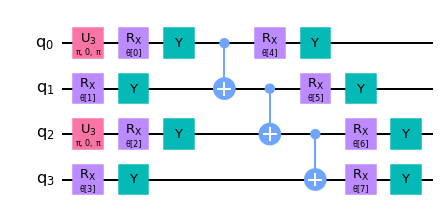

In [2]:
# from qusetta import Qiskit

num_vars = 2*vqe(ansatz_id=3).get_num_qubits()*vqe(ansatz_id=3).repitition
np.random.seed(0)
params = np.random.randn(num_vars)

# ansatz = EfficientSU2(vqe(ansatz_id=1).get_num_qubits(), entanglement="linear", reps=1, su2_gates=['rx', 'y'])
# ansatz.compose(vqe(ansatz_id=1).init_state, front=True, inplace=True)
# ansatz = ansatz.decompose()
ansatz = vqe(ansatz_id=1).get_ansatz(params=params)
ansatz.bind_parameters(params)
# ansatz = Qiskit.to_cirq(ansatz)
# print(ansatz.parameters)
# ansatz.assign_parameters({θ[0]:params[0],θ[1]:params[1],θ[2]:params[2],θ[3]:params[3],θ[4]:params[4],
                        # θ[5]:params[5],θ[6]:params[6]})
# ansatz.draw()
# ansatz = fold_gates_from_right(ansatz, scale_factor = 2.)
ansatz.draw('mpl')
# num_parameters = ansatz.num_parameters
# print(ansatz)

In [ ]:
ansatz.draw('mpl')

In [ ]:
print("Num of Parameters : %d"%(num_parameters))

In [ ]:
device_backend = FakeVigo()
simulator = Aer.get_backend('qasm_simulator')
q_instance = QuantumInstance(simulator, shots=1024)
q_instance_noise = QuantumInstance(device_backend, shots= 1024)

In [ ]:
def executor_noisy(ansatz):

    # ansatz = vqe(ansatz_id=3).get_ansatz(params)

    qubit_op = vqe(ansatz_id=3).create_hamiltonian()
    psi = CircuitStateFn(ansatz)

    expectation = ExpectationFactory.build(operator=qubit_op, backend=q_instance_noise)
    measurable_expression = expectation.convert(StateFn(qubit_op, is_measurement=True))
    expect_op = measurable_expression.compose(psi).reduce() 
    
    sampled_expect_op = CircuitSampler(q_instance).convert(expect_op) 
    energy_evaluation = np.real(sampled_expect_op.eval())


    return energy_evaluation

def executor(ansatz):

    # ansatz = vqe(ansatz_id=3).get_ansatz(params)

    qubit_op = vqe(ansatz_id=3).create_hamiltonian()
    psi = CircuitStateFn(ansatz)

    expectation = ExpectationFactory.build(operator=qubit_op, backend=q_instance)
    measurable_expression = expectation.convert(StateFn(qubit_op, is_measurement=True))
    expect_op = measurable_expression.compose(psi).reduce() 
    
    sampled_expect_op = CircuitSampler(q_instance).convert(expect_op) 
    energy_evaluation = np.real(sampled_expect_op.eval())


    return energy_evaluation

def executor_zne(params):
    ansatz = vqe(ansatz_id=3).get_ansatz(params)
    zne_energy_evaluation = execute_with_zne(ansatz, executor_noisy, factory=richardson_fac)
    return zne_energy_evaluation

In [ ]:
linear_fac = LinearFactory(scale_factors=[1.0, 2.0])
richardson_fac = RichardsonFactory(scale_factors=[1.0, 2.0, 3.0])
poly_fac = PolyFactory(scale_factors=[1.0, 2.0, 3.0, 4.0], order=2)


In [ ]:
optimizer = COBYLA(maxiter=50, tol = 1e-2, disp=True)

num_vars = 2*vqe(ansatz_id=3).get_num_qubits()*vqe(ansatz_id=3).repitition
np.random.seed(0)
params = np.random.randn(num_vars)

mit_out = optimizer.optimize(num_vars=num_vars, objective_function=executor_zne, initial_point=params)
print(" mitigated results is : ",mit_out)

non_mit_out = optimizer.optimize( fun=executor, x0=params)
print("non mitigated result is:", non_mit_out)

In [ ]:
# noisy results is :  (array([ 1.76405235,  1.40015721,  1.97873798,  2.2408932 ,  1.86755799,
#        -0.97727788,  0.95008842, -0.15135721]), -0.8275455323483708, 5)
# non noisy result is: (array([ 1.76405235,  1.40015721,  1.97873798,  3.2408932 ,  1.86755799,
#        -0.97727788,  0.95008842, -0.15135721]), -0.8059492719293181, 5)
# noisy results is :  (array([ 3.06818017,  3.08213461,  3.00964483,  3.82645365,  3.11884604,
#         0.05341333,  0.15247816, -2.43353714]), -1.8181757008830428, 50)
# non noisy result is: (array([ 3.26466318,  3.16031465,  6.33002314,  2.58272034,  3.0681412 ,
#         0.00949041,  3.08251081, -0.75905788]), -1.8075947625360558, 50)
# mitigated results is :  (array([-0.47193863,  0.78546591,  1.89407963,  0.69711902, -1.02046597,
#        -0.8650463 ,  0.25066349,  0.70675831]), -1.1948247602069397, 5)
# non mitigated result is: (array([-0.47193863,  0.78546591,  1.89407963,  0.69711902, -1.02046597,
#        -0.8650463 ,  0.25066349,  0.70675831]), -1.2126394164823253, 5)

#ibm_nairobi

# iteration 1 mitigated results is :  {   'fun': -1.66940365157224,
#     'jac': None,
#     'nfev': 60,
#     'nit': None,
#     'njev': None,
#     'x': array([ 0.13382345, -0.00511143, -0.39420754,  2.24686456,  0.28874861,
#        -0.39285493,  2.83978808, -0.85477154])}
# iteration 1 non - mitigated results is :  {   'fun': -1.7721507261206209,
#     'jac': None,
#     'nfev': 60,
#     'nit': None,
#     'njev': None,
#     'x': array([ 0.09917122,  0.02386141,  3.00154566,  1.34595672,  0.06757196,
#        -0.10186097, -0.103562  ,  1.27573624])}

# iteration 1 mitigated results is :  {   'fun': -1.7945087710337202,
#     'jac': None,
#     'nfev': 60,
#     'nit': None,
#     'njev': None,
#     'x': array([-0.01490178,  0.06848527,  3.05397574,  0.70348869, -0.07625432,
#         0.09289321, -0.08433714,  0.94136975])}
# iteration 1 non - mitigated results is :  {   'fun': -1.7138294141224015,
#     'jac': None,
#     'nfev': 60,
#     'nit': None,
#     'njev': None,
#     'x': array([ 0.09229285,  0.1161415 ,  2.82149769,  1.14061925, -0.36302725,
#        -0.05929736, -0.27993539,  0.77760852])}

#ibm_oslo

# iteration 1 mitigated results is :  {   'fun': -1.3059257584642474,
#     'jac': None,
#     'nfev': 40,
#     'nit': None,
#     'njev': None,
#     'x': array([-0.0674539 , -2.79963614,  0.22575407,  0.29424853, -1.9000987 ,
#        -2.0271745 , -0.15109993,  0.07898656])}
# iteration 1 non - mitigated results is :  {   'fun': -1.7294826457746086,
#     'jac': None,
#     'nfev': 40,
#     'nit': None,
#     'njev': None,
#     'x': array([ 0.11469049, -2.93243501,  0.1695688 ,  0.35093999,  0.22772765,
#        -3.45266637,  0.28758164,  0.04255242])}

# iteration 2 mitigated results is :  {   'fun': -1.6833032256642346,
#     'jac': None,
#     'nfev': 40,
#     'nit': None,
#     'njev': None,
#     'x': array([-0.22600542,  0.11786411, -0.41314393,  2.24730424,  0.49230674,
#         0.23907177, -2.81590973, -0.71446382])}
# iteration 2 non - mitigated results is :  {   'fun': -1.6816917282440844,
#     'jac': None,
#     'nfev': 40,
#     'nit': None,
#     'njev': None,
#     'x': array([ 0.30970218,  0.33504403, -2.77056262, -1.37842972, -0.05915053,
#         0.23318963, -0.00446822, -1.7134913 ])}

In [ ]:
# iteration 1 mitigated results is :  {   'fun': -1.5315870084519823,
#     'jac': None,
#     'nfev': 10,
#     'nit': None,
#     'njev': None,
#     'x': array([ 1.16137166,  0.91129187,  0.63785721,  0.02070214, -0.29063367,
#         1.34721003, -1.61821419,  0.01705373])}
# iteration 1 non - mitigated results is :  {   'fun': -0.9143059713832764,
#     'jac': None,
#     'nfev': 10,
#     'nit': None,
#     'njev': None,
#     'x': array([ 0.93575768,  0.13070714,  1.73932815,  1.03612316, -1.64507855,
#         2.13955629,  0.17131887, -1.07815363])}
# iteration 2 mitigated results is :  {   'fun': -0.837407934780607,
#     'jac': None,
#     'nfev': 10,
#     'nit': None,
#     'njev': None,
#     'x': array([ 1.14432436, -0.28856664,  2.20075773, -0.38315752, -0.09910721,
#        -1.46450603, -1.00402624, -1.05135356])}
# iteration 2 non - mitigated results is :  {   'fun': -0.9157393187347199,
#     'jac': None,
#     'nfev': 10,
#     'nit': None,
#     'njev': None,
#     'x': array([-0.87565759, -1.35031235,  1.12459938,  0.9452799 , -0.58558204,
#        -2.38416082, -2.59881808,  2.27616407])}
# iteration 1 mitigated results is :  {   'fun': -1.5028161958490034,
#     'jac': None,
#     'nfev': 100,
#     'nit': None,
#     'njev': None,
#     'x': array([-1.442172  , -0.82574465,  1.96268585,  0.09161501, -1.09400461,
#        -0.03519163, -2.54273322,  0.38797168])}
# iteration 1 non - mitigated results is :  {   'fun': -0.575704013083465,
#     'jac': None,
#     'nfev': 100,
#     'nit': None,
#     'njev': None,
#     'x': array([-1.44096031,  0.52731784, -1.24384286, -2.43251113,  5.07571309,
#        -4.61523807,  4.96806721,  1.26303179])}
# iteration 1 mitigated results is :  {   'fun': -0.7458970602973424,
#     'jac': None,
#     'nfev': 100,
#     'nit': None,
#     'njev': None,
#     'x': array([ 0.72355629,  1.6167047 ,  1.04011456,  5.27163992,  0.3470586 ,
#         0.9317603 , -0.40846485,  0.38626826])}
# iteration 1 non - mitigated results is : 'optimal_point': array([ 0.07301272, -0.17092599, -0.26178223,  0.15016342,  1.97418783,
#         0.02463811, -3.09412786,  0.43133808]),
#     'optimal_value': -1.141726266177079,
#     'optimizer_evals': None,
#     'optimizer_time': 64.11112999916077}
# iteration 1 mitigated results is :  {   'fun': -0.37930671303835234,
#     'jac': None,
#     'nfev': 78,
#     'nit': None,
#     'njev': None,
#     'x': array([ 1.76178491,  0.39607655,  1.98036449,  2.2470722 ,  1.86508888,
#        -0.97641842,  0.95224922, -0.1533472 ])}
# iteration 2 mitigated results is :  {   'fun': -1.2788576099299978,
#     'jac': None,
#     'nfev': 82,
#     'nit': None,
#     'njev': None,
#     'x': array([-1.20038336, -0.15766618,  2.51467313, -0.04742453, -0.19938111,
#        -0.39486362,  0.2980973 ,  1.54039262])}
# iteration 1 mitigated results is :  {   'fun': -1.4494074866155564,
#     'jac': None,
#     'nfev': 81,
#     'nit': None,
#     'njev': None,
#     'x': array([ 1.76257697,  0.40280337,  1.97440986,  2.2425905 ,  1.87152136,
#        -0.98114738,  0.95187786, -0.15477238])}
# iteration 2 mitigated results is :  {   'fun': -1.3063700898582205,
#     'jac': None,
#     'nfev': 76,
#     'nit': None,
#     'njev': None,
#     'x': array([ 2.27433323, -1.17075108,  0.6853636 , -0.26855465,  0.83018499,
#        -0.13557901,  1.2196467 , -0.19254844])}
# 'optimal_point': array([ 3.14210094, -0.14407911,  0.07609285, -1.5421285 , -2.75252062,
#         3.06935874, -0.00792909, -1.56722087]),
#     'optimal_value': -1.6981887099209614,
#     'optimizer_evals': None,
#     'optimizer_time': 42.09995937347412}
# 'optimal_point': array([-0.16002846, -0.00360572, -0.07560506, -2.76633386,  0.55985922,
#         0.23869678,  2.88725794,  0.49253975]),
#     'optimal_value': -1.6106769465693969,
#     'optimizer_evals': None,
#     'optimizer_time': 43.320215463638306}
# iteration 1 mitigated results is :  {   'fun': -1.4425383881366955,
#     'jac': None,
#     'nfev': 81,
#     'nit': None,
#     'njev': None,
#     'x': array([ 1.76297971,  0.40062613,  1.97909407,  2.23962405,  1.86414573,
#        -0.97866034,  0.95012615, -0.14950326])}
# iteration 2 mitigated results is :  {   'fun': -1.0517526781751914,
#     'jac': None,
#     'nfev': 70,
#     'nit': None,
#     'njev': None,
#     'x': array([ 2.27779822, -1.171149  ,  0.69771423, -0.26835324,  0.83025416,
#        -0.13418681,  1.22136228, -0.19279102])}


# iteration 1 mitigated results is :  {   'fun': -1.7931956817821189,
#     'jac': None,
#     'nfev': 100,
#     'nit': None,
#     'njev': None,
#     'x': array([2.96833974, 3.13118315, 6.29201039, 3.4378856 , 2.99234946,
#        0.07499961, 3.12556403, 0.38277864])}
# iteration 2 mitigated results is :  {   'fun': -1.7654766547401188,
#     'jac': None,
#     'nfev': 97,
#     'nit': None,
#     'njev': None,
#     'x': array([-0.06812229,  0.07155553,  3.20550841,  0.97005827,  0.18883808,
#        -0.04105214,  0.42129944,  1.16874764])}

#SPSA

# iteration 1 mitigated results is :  {   'fun': -1.7815234470172567,
#     'jac': None,
#     'nfev': 200,
#     'nit': None,
#     'njev': None,
#     'x': array([ 3.12265924,  0.02613222,  3.12748637,  0.59714033,  3.09774725,
#        -3.17091637,  3.13014918,  3.75943101])}
# iteration 2 mitigated results is :  {   'fun': -1.7995754745426742,
#     'jac': None,
#     'nfev': 200,
#     'nit': None,
#     'njev': None,
#     'x': array([ 0.00643136,  0.01284195, -3.16834769,  1.44232042, -0.03523385,
#        -0.04486715,  0.06020729,  1.47889219])}
# iteration 3 mitigated results is :  {   'fun': -1.8090380814107456,
#     'jac': None,
#     'nfev': 200,
#     'nit': None,
#     'njev': None,
#     'x': array([ 3.14224632, -0.01088977, -0.02655823, -0.02917516, -3.05705229,
#         3.1458764 ,  0.01767865, -0.00801813])}
# iteration 4 mitigated results is :  {   'fun': -1.2713283223108203,
#     'jac': None,
#     'nfev': 200,
#     'nit': None,
#     'njev': None,
#     'x': array([ 3.07170801,  0.08579809,  0.01971879, -0.54771601,  0.59261097,
#         2.71241673, -0.06456654, -0.48677175])}
# iteration 5 mitigated results is :  {   'fun': -1.7868446608558022,
#     'jac': None,
#     'nfev': 200,
#     'nit': None,
#     'njev': None,
#     'x': array([ 0.02149804, -3.16414128, -0.02754018, -1.5856223 , -0.03437481,
#         3.18630832, -0.03921472, -1.70038253])}
# iteration 6 mitigated results is :  {   'fun': -1.7790839488284955,
#     'jac': None,
#     'nfev': 200,
#     'nit': None,
#     'njev': None,
#     'x': array([-0.02124795, -0.0263772 , -3.11564356,  1.35624032, -0.03505847,
#         0.04676834, -0.01610252,  1.35183547])}



In [ ]:
# iteration 1 mitigated results is :  {   'fun': -0.9658404696362577,
#     'jac': None,
#     'nfev': 92,
#     'nit': None,
#     'njev': None,
#     'x': array([ 3.33921058,  0.09651871,  3.09672445,  2.39742442,  3.25867574,
#        -0.01537892,  0.05647356, -0.75569128])}
# iteration 2 mitigated results is :  {   'fun': -0.9682235460274423,
#     'jac': None,
#     'nfev': 100,
#     'nit': None,
#     'njev': None,
#     'x': array([ 0.23705052,  0.21078254,  0.01397208,  2.95737572, -0.08490576,
#         3.08623142,  0.16597758, -0.26935422])}


In [ ]:
# {   'aux_operator_eigenvalues': None,
#     'cost_function_evals': 92,
#     'eigenstate': {   '0001': 0.03162277660168379,
#                       '0010': 0.03162277660168379,
#                       '0011': 0.9939818911831342,
#                       '1011': 0.06324555320336758,
#                       '1100': 0.05477225575051661,
#                       '1101': 0.03162277660168379,
#                       '1111': 0.044721359549995794},
#     'eigenvalue': (-0.9918109042760271+0j),
#     'optimal_parameters': {   ParameterVectorElement(θ[5]): 0.03532876724944283,
#                               ParameterVectorElement(θ[4]): 0.08134166570762036,
#                               ParameterVectorElement(θ[3]): 1.6512774717645307,
#                               ParameterVectorElement(θ[2]): -3.017092699580898,
#                               ParameterVectorElement(θ[1]): -3.238467823695794,
#                               ParameterVectorElement(θ[6]): 0.00383858506054569,
#                               ParameterVectorElement(θ[0]): 0.07961956081728905,
#                               ParameterVectorElement(θ[7]): -1.6433954261952726},
#     'optimal_point': array([ 0.07961956, -3.23846782, -3.0170927 ,  1.65127747,  0.08134167,
#         0.03532877,  0.00383859, -1.64339543]),
#     'optimal_value': -0.9918109042760271,
#     'optimizer_evals': None,
#     'optimizer_time': 46.6316237449646}

# {   'aux_operator_eigenvalues': None,
#     'cost_function_evals': 90,
#     'eigenstate': {   '0000': 0.08366600265340755,
#                       '0001': 0.15165750888103102,
#                       '0010': 0.17606816861659008,
#                       '0011': 0.03162277660168379,
#                       '0100': 0.1341640786499874,
#                       '0110': 0.35496478698597694,
#                       '0111': 0.08366600265340755,
#                       '1000': 0.07071067811865475,
#                       '1001': 0.07071067811865475,
#                       '1010': 0.17029386365926402,
#                       '1100': 0.2810693864511039,
#                       '1101': 0.044721359549995794,
#                       '1110': 0.8018728078691783,
#                       '1111': 0.15491933384829668},
#     'eigenvalue': (-0.666415669844135+0j),
#     'optimal_parameters': {   ParameterVectorElement(θ[2]): -0.28349616468490546,
#                               ParameterVectorElement(θ[7]): 2.538703108142127,
#                               ParameterVectorElement(θ[3]): 3.305685079791761,
#                               ParameterVectorElement(θ[4]): -0.29154724808854776,
#                               ParameterVectorElement(θ[0]): 3.451949546412126,
#                               ParameterVectorElement(θ[1]): -3.059851678052927,
#                               ParameterVectorElement(θ[6]): 3.108143432049321,
#                               ParameterVectorElement(θ[5]): 2.571645526143822},
#     'optimal_point': array([ 3.45194955, -3.05985168, -0.28349616,  3.30568508, -0.29154725,
#         2.57164553,  3.10814343,  2.53870311]),
#     'optimal_value': -0.666415669844135,
#     'optimizer_evals': None,
#     'optimizer_time': 117.95474457740784}
